# Libraries and Helper Functions

In [17]:
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
import seaborn as sn
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [28]:
def model_evaluation(y, predictions, label, scores_df):
    class_labels = ['Not Readmitted', 'Readmitted']
    #calculate accuracy
    accuracy = accuracy_score(y, predictions)
    print('{0} Accuracy: {1:.4f}'.format(label, accuracy))
    #calculate precision
    precision = precision_score(y, predictions)
    print('{0} Precision: {1:.4f}'.format(label, precision))
    #calculate recall
    recall = recall_score(y, predictions)
    print('{0} Recall: {1:.4f}'.format(label, recall))
    #calculate f1
    f1 = f1_score(y, predictions)
    print('{0} F1: {1:.4f}'.format(label, f1))    
    cm = confusion_matrix(y, predictions)
    df_cm = np.transpose( np.transpose(cm) / cm.astype(np.float).sum(axis=1) )
    df_cm = pd.DataFrame(df_cm, index = class_labels, columns = class_labels)
    plt.figure(figsize = (10,7))
    sn.heatmap(df_cm, annot=True, fmt='.3f', cmap='Blues')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    
    scores_df_add = pd.DataFrame([[label, accuracy, precision, recall, f1]],
                             columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1'])
    scores_df = pd.concat([scores_df, scores_df_add])
    return scores_df

In [45]:
def plot_roc(y, predictions, label):
    
    models = predictions.columns
    # Compute fpr, tpr, thresholds and roc auc
    for model in models:
        prediction = predictions[model]
        fpr, tpr, thresholds = roc_curve(y, prediction)
        roc_auc = auc(fpr, tpr)
        # Plot ROC curve
        plt.plot(fpr, tpr, label=model + ' ROC curve (area = %0.3f)' % roc_auc)
        
    plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate or (1 - Specifity)')
    plt.ylabel('True Positive Rate or (Sensitivity)')
    plt.title('{0} ROC Curves'.format(label))
    plt.legend(loc="lower right")

    plt.show()

In [65]:
def plot_cost_effectiveness(y, predictions, label):

    models = predictions.columns
    
    C_INTERVENTION = 1300 
    C_READMISSION = 13679
    P_REDUCTION = 1.0
    P_ALLPATIENT_READMISSION = y.sum() * 1.0 / y.shape[0]
    
    PROBABILITY_THRESHOLDS = xrange(0, 100, 1)
    
    for model in models:
        probabilities = predictions[model]
        costs = []
        for i in PROBABILITY_THRESHOLDS:
            i = i * 1.0 / 100.0
            prediction_values = probabilities > i
            total_cost = 0
            for actual, predicted in zip(y, prediction_values):
                c_intervention = C_INTERVENTION if predicted else 0
                p_reduction = P_REDUCTION if predicted and actual else 0
                total_cost += (c_intervention + P_ALLPATIENT_READMISSION * (1.0 - p_reduction) * C_READMISSION)
            costs.append(total_cost)
        
        plot_title = '{0} Costs | min = ${1:,}'.format(model, min(costs))
        plt.plot(PROBABILITY_THRESHOLDS, costs, label = plot_title)
    
    plt.xlabel('Probability Threshold (%)')
    plt.ylabel('Program Cost')
    plt.title('{0} Program Costs'.format(label))
    plt.legend(loc="lower right")
    
    plt.show()
    

In [34]:
def get_feature_importance(feature_importance, features):
    indices = np.argsort(feature_importance)[::-1]
    feature_importance = [feature_importance[i] for i in indices]
    features = [features[i] for i in indices]
    features_index = range(1, len(features) + 1)
    num_features = len(features)
    plt.figure(figsize=(20,20))
    plt.bar(features_index[:num_features], feature_importance[:num_features], align = 'center')
    plt.xticks(features_index[:num_features], features[:num_features], rotation = 'vertical')
    plt.show()

# Load Model Results

In [24]:
parameters_df = pd.read_csv('model_parameters_dataset.csv')
feature_importance_df = pd.read_csv('model_feature_importance_dataset.csv')
train_predictions_df = pd.read_csv('model_train_predictions_dataset.csv')
test_predictions_df = pd.read_csv('model_test_predictions_dataset.csv')

scores_df = pd.DataFrame()

# Best Model Parameters

In [25]:
for i in range(parameters_df.shape[0]):
    print('{0} = {1}'.format(parameters_df.iloc[i]['Name'], parameters_df.iloc[i]['Best Parameters']))
    print('\n')

Logistic Regression = {'penalty': 'l1', 'C': 10.0, 'random_state': 42, 'class_weight': 'balanced'}


XGBoost = {'colsample_bytree': 0.5, 'learning_rate': 0.01, 'min_child_weight': 1, 'n_estimators': 1000, 'subsample': 1, 'seed': 42, 'objective': 'binary:logistic', 'max_depth': 3, 'gamma': 0}


Random Forest = {'min_samples_leaf': 1, 'n_estimators': 1000, 'random_state': 42, 'max_features': 'log2', 'max_depth': 100, 'class_weight': 'balanced'}




# Individual Model Results

## Blank Guess Models

### No Readmission

Blind Guess None - Train Accuracy: 0.8235
Blind Guess None - Train Precision: 0.0000
Blind Guess None - Train Recall: 0.0000
Blind Guess None - Train F1: 0.0000


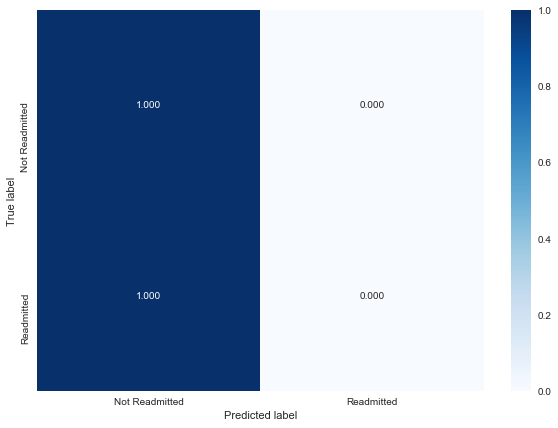

Blind Guess None - Test Accuracy: 0.8175
Blind Guess None - Test Precision: 0.0000
Blind Guess None - Test Recall: 0.0000
Blind Guess None - Test F1: 0.0000


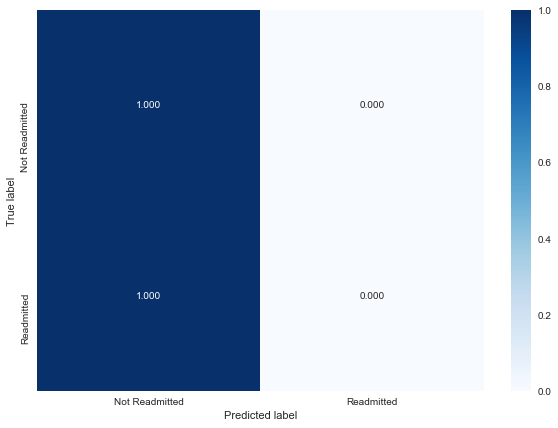

In [29]:
model_name = 'Blind Guess None'
scores_df = model_evaluation(train_predictions_df['READMISSION'],
                                    train_predictions_df[model_name + '_Train_Predictions'],
                                   model_name + ' - Train', scores_df)
scores_df = model_evaluation(test_predictions_df['READMISSION'],
                                    test_predictions_df[model_name + '_Test_Predictions'],
                                   model_name + ' - Test', scores_df)

### Readmission

Blind Guess All - Train Accuracy: 0.1765
Blind Guess All - Train Precision: 0.1765
Blind Guess All - Train Recall: 1.0000
Blind Guess All - Train F1: 0.3000


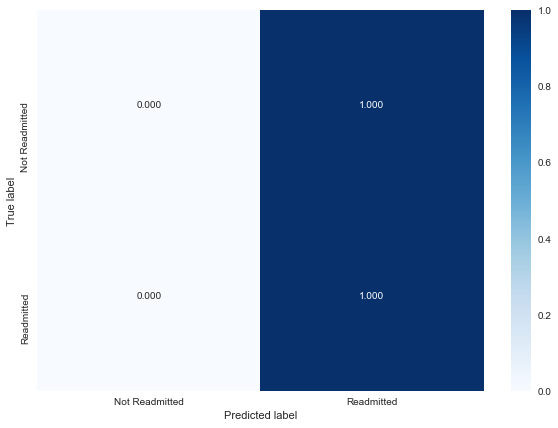

Blind Guess All - Test Accuracy: 0.1825
Blind Guess All - Test Precision: 0.1825
Blind Guess All - Test Recall: 1.0000
Blind Guess All - Test F1: 0.3086


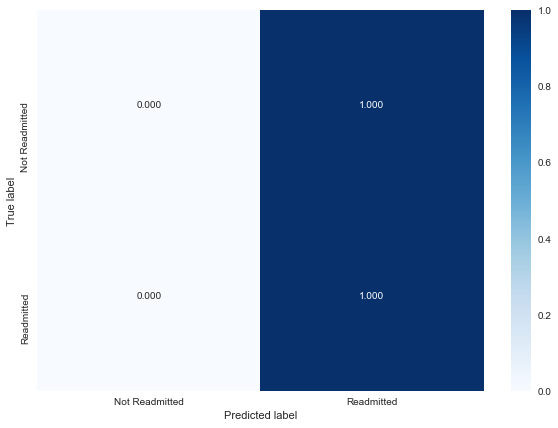

In [31]:
model_name = 'Blind Guess All'
scores_df = model_evaluation(train_predictions_df['READMISSION'],
                                    train_predictions_df[model_name + '_Train_Predictions'],
                                   model_name + ' - Train', scores_df)
scores_df = model_evaluation(test_predictions_df['READMISSION'],
                                    test_predictions_df[model_name + '_Test_Predictions'],
                                   model_name + ' - Test', scores_df)

# Logistic Regression

Logistic Regression - Train Accuracy: 0.6153
Logistic Regression - Train Precision: 0.2851
Logistic Regression - Train Recall: 0.7827
Logistic Regression - Train F1: 0.4180


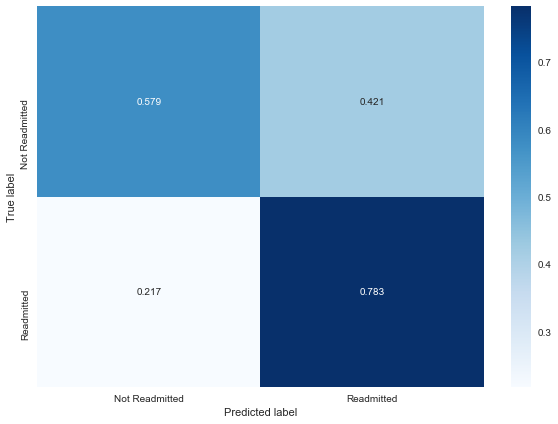

Logistic Regression - Test Accuracy: 0.6082
Logistic Regression - Test Precision: 0.2898
Logistic Regression - Test Recall: 0.7905
Logistic Regression - Test F1: 0.4241


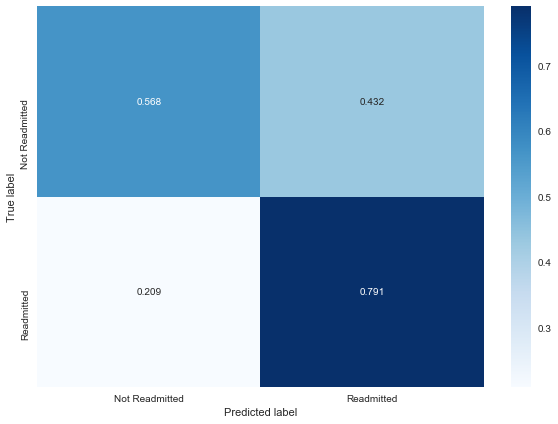

In [33]:
model_name = 'Logistic Regression'
scores_df = model_evaluation(train_predictions_df['READMISSION'],
                                    train_predictions_df[model_name + '_Train_Predictions'],
                                   model_name + ' - Train', scores_df)
scores_df = model_evaluation(test_predictions_df['READMISSION'],
                                    test_predictions_df[model_name + '_Test_Predictions'],
                                   model_name + ' - Test', scores_df)

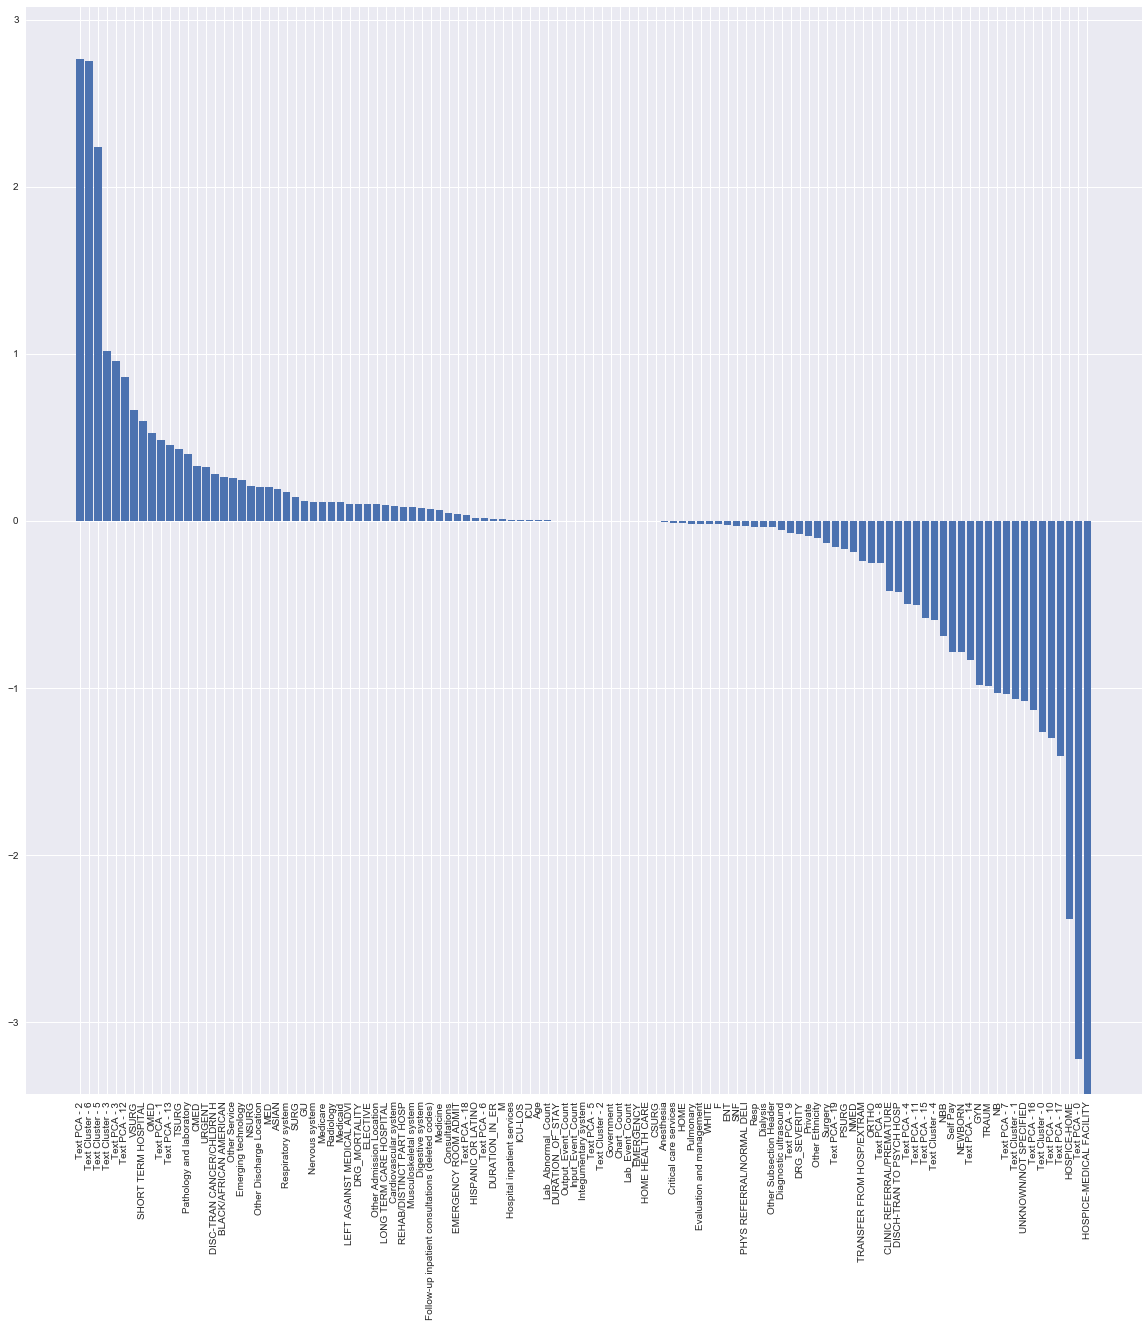

In [35]:
get_feature_importance(feature_importance_df[model_name], feature_importance_df['Features'])

## Random Forest

Random Forest - Train Accuracy: 1.0000
Random Forest - Train Precision: 1.0000
Random Forest - Train Recall: 1.0000
Random Forest - Train F1: 1.0000


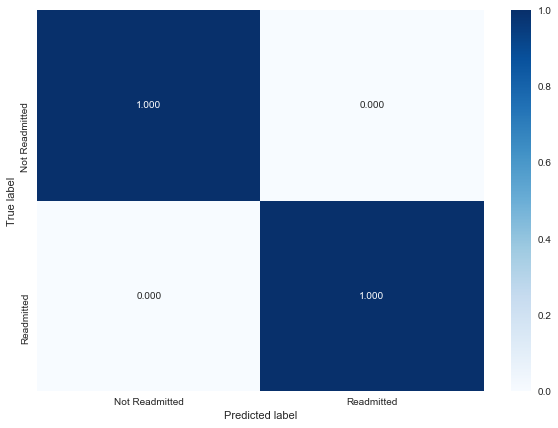

Random Forest - Test Accuracy: 0.8364
Random Forest - Test Precision: 0.8768
Random Forest - Test Recall: 0.1204
Random Forest - Test F1: 0.2117


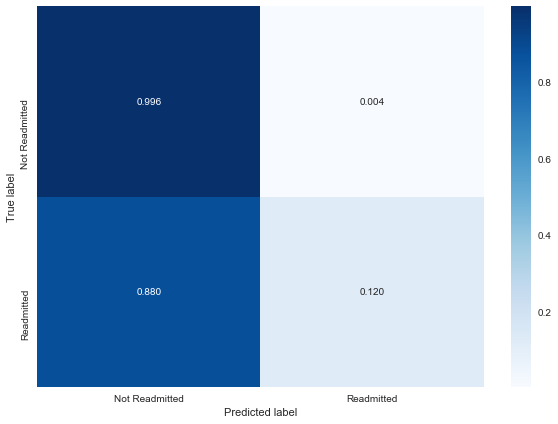

In [36]:
model_name = 'Random Forest'
scores_df = model_evaluation(train_predictions_df['READMISSION'],
                                    train_predictions_df[model_name + '_Train_Predictions'],
                                   model_name + ' - Train', scores_df)
scores_df = model_evaluation(test_predictions_df['READMISSION'],
                                    test_predictions_df[model_name + '_Test_Predictions'],
                                   model_name + ' - Test', scores_df)

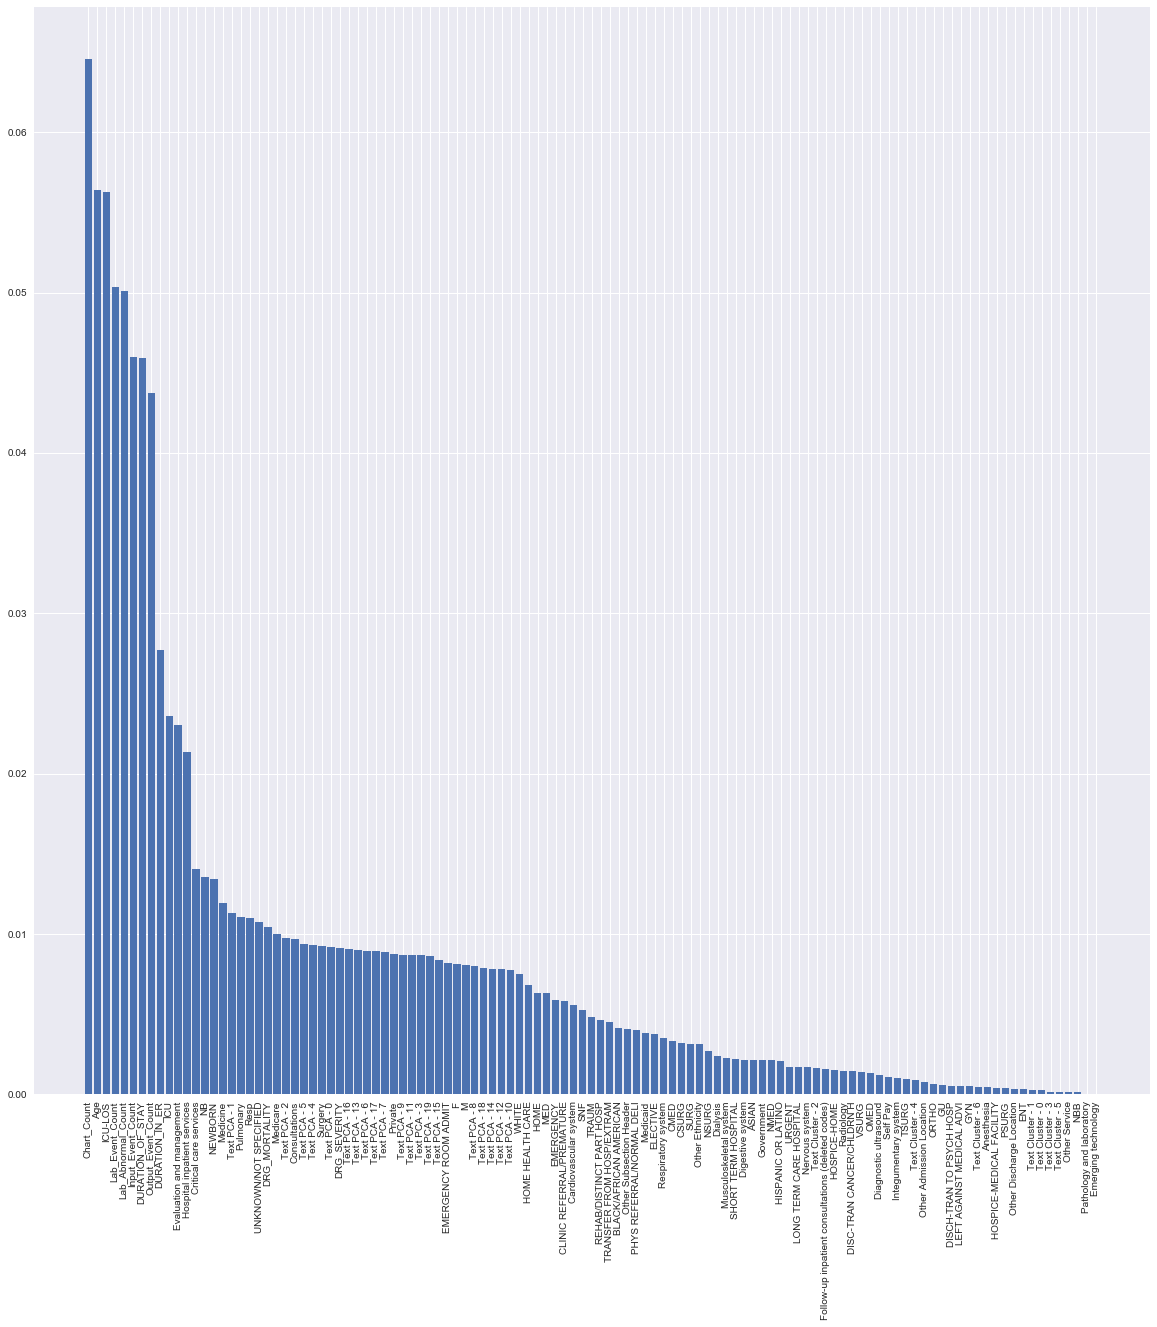

In [37]:
get_feature_importance(feature_importance_df[model_name], feature_importance_df['Features'])

## XGBoost

XGBoost - Train Accuracy: 0.8431
XGBoost - Train Precision: 0.9557
XGBoost - Train Recall: 0.1162
XGBoost - Train F1: 0.2072


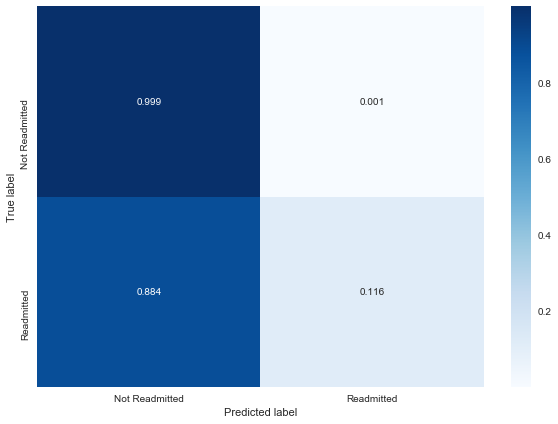

XGBoost - Test Accuracy: 0.8377
XGBoost - Test Precision: 0.9670
XGBoost - Test Recall: 0.1145
XGBoost - Test F1: 0.2048


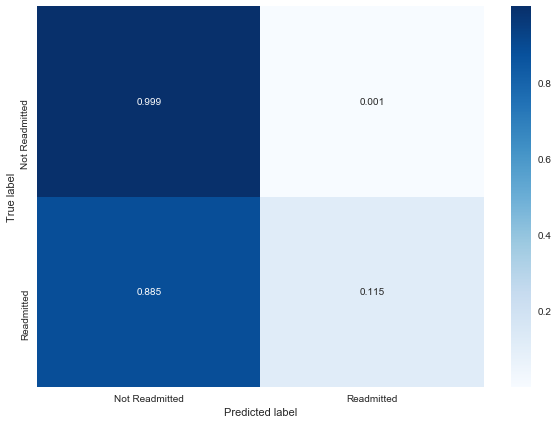

In [38]:
model_name = 'XGBoost'
scores_df = model_evaluation(train_predictions_df['READMISSION'],
                                    train_predictions_df[model_name + '_Train_Predictions'],
                                   model_name + ' - Train', scores_df)
scores_df = model_evaluation(test_predictions_df['READMISSION'],
                                    test_predictions_df[model_name + '_Test_Predictions'],
                                   model_name + ' - Test', scores_df)

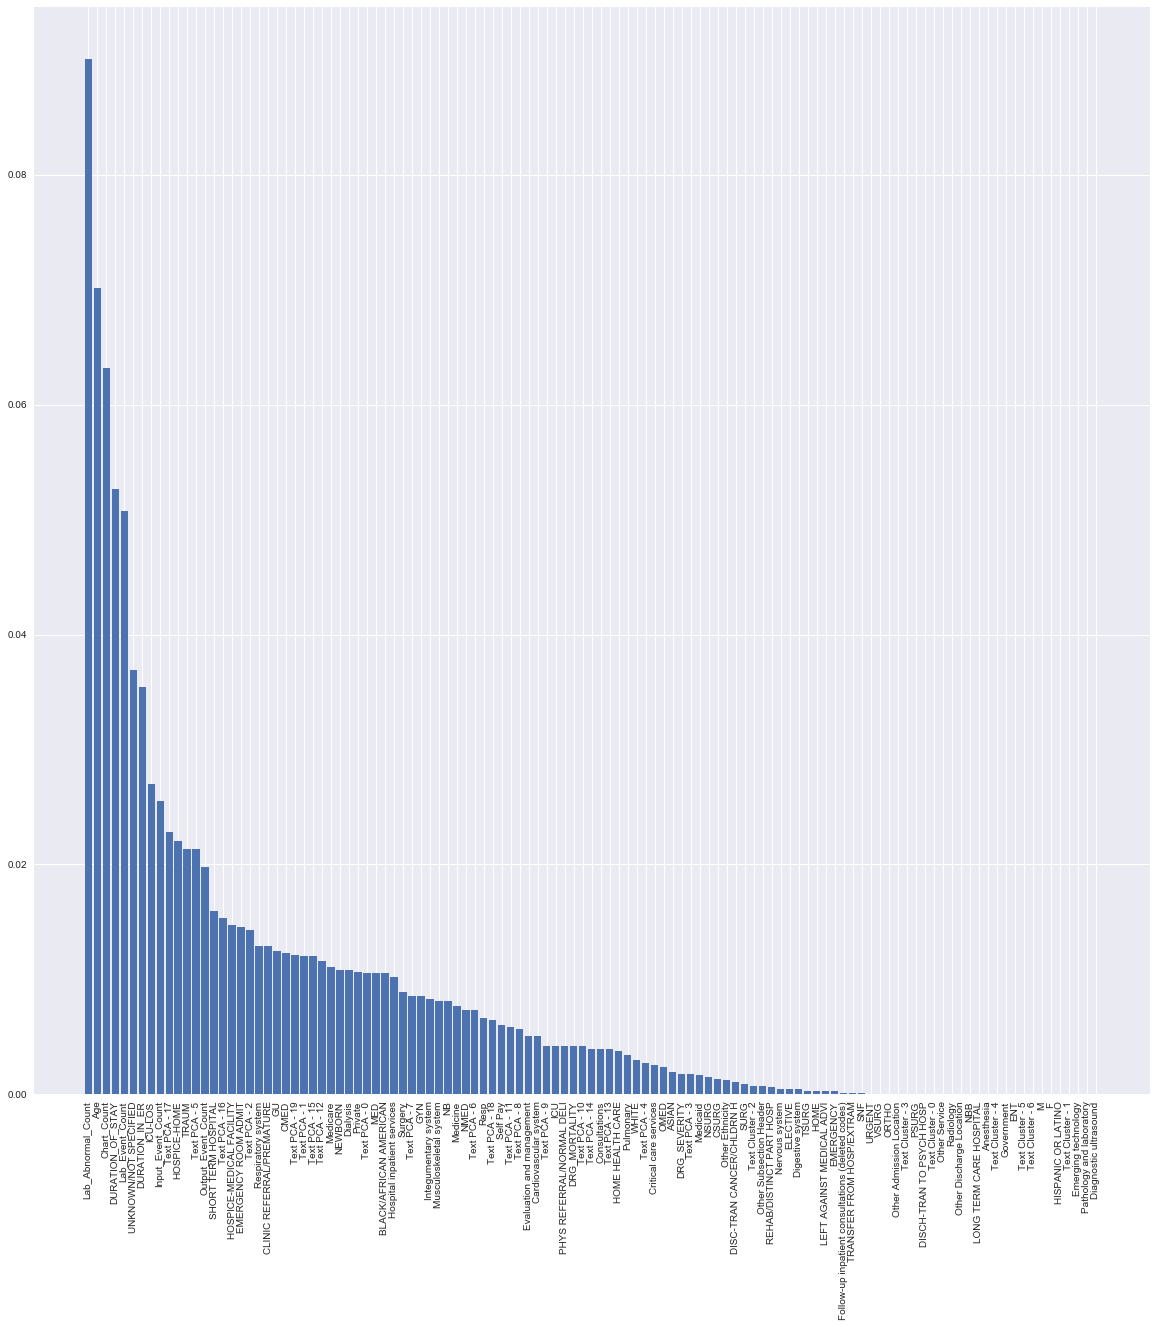

In [39]:
get_feature_importance(feature_importance_df[model_name], feature_importance_df['Features'])

## SVM

## All Models

In [40]:
scores_df

,Model,Accuracy,Precision,Recall,F1
0,Blind Guess None - Train,0.823519,0.000000,0.000000,0.000000
0,Blind Guess None - Test,0.817523,0.000000,0.000000,0.000000
0,Blind Guess All - Train,0.176481,0.176481,1.000000,0.300015
0,Blind Guess All - Test,0.182477,0.182477,1.000000,0.308635
0,Blind Guess All - Train,0.176481,0.176481,1.000000,0.300015
0,Blind Guess All - Test,0.182477,0.182477,1.000000,0.308635
0,Logistic Regression - Train,0.615309,0.285119,0.782711,0.417980
0,Logistic Regression - Test,0.608216,0.289769,0.790501,0.424084
0,Random Forest - Train,1.000000,1.000000,1.000000,1.000000
0,Random Forest - Test,0.836400,0.876777,0.120364,0.211670


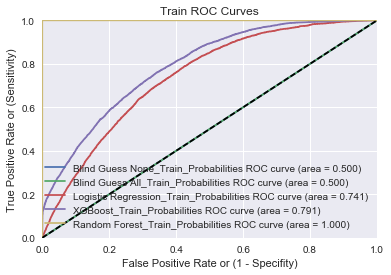

In [46]:
train_probability_columns = [column for column in train_predictions_df.columns if 'Probabilities' in column]
plot_roc(train_predictions_df['READMISSION'], train_predictions_df[train_probability_columns], 'Train')

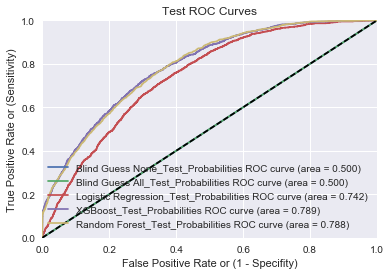

In [47]:
test_probability_columns = [column for column in test_predictions_df.columns if 'Probabilities' in column]
plot_roc(test_predictions_df['READMISSION'], test_predictions_df[test_probability_columns], 'Test')

In [ ]:
plot_cost_effectiveness(train_predictions_df['READMISSION'], train_predictions_df[train_probability_columns], 'Train')

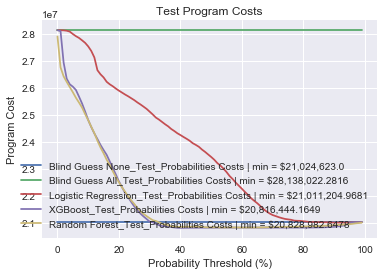

In [66]:
plot_cost_effectiveness(test_predictions_df['READMISSION'], test_predictions_df[test_probability_columns], 'Test')

 # Ensemble